# Midterm Project: BRT Walkshed Demographics in Atlanta and Los Angeles (Aziz Fellague and Andrew Jarnagin)
This notebook was written by Andrew and contains analysis for the Atlanta portion of the project. Aziz's Los Angeles analysis is saved in a separate notebook.

Our research question is to investigate the characteristics of neighborhoods served by proposed Bus Rapid Transit routes in Los Angeles and Atlanta.

In [1]:
import pandas as pd

import geopandas as gpd

import matplotlib.pyplot as plt

import networkx as nx

import osmnx as ox

import contextily as ctx

## Import Census data
For the midterm, we will analyze race, nativity/foreign born, commute mode, and population density for census tracts within the MARTA service area (Clayton, Dekalb, and Fulton counties). ACS 2019 5-year data tract-level data for race, nativity, and commute mode was downloaded from Census Explorer. Population Density was downloaded from Social Explorer, wtih the same parameters.

In [2]:
#import census data
race = gpd.read_file('midterm_data/Race_B03002.geojson')
nativity = gpd.read_file('midterm_data/Nativity_B05012.geojson')
mode = gpd.read_file('midterm_data/CommuteMode_B08301.geojson')

In [3]:
#clean the data
race.head()

geoid                              name  B03002001  \
0  14000US13063040202  Census Tract 402.02, Clayton, GA     2850.0   
1  14000US13063040203  Census Tract 402.03, Clayton, GA     3735.0   
2  14000US13063040204  Census Tract 402.04, Clayton, GA     4648.0   
3  14000US13063040302  Census Tract 403.02, Clayton, GA     5740.0   
4  14000US13063040303  Census Tract 403.03, Clayton, GA     6666.0   

   B03002001, Error  B03002002  B03002002, Error  B03002003  B03002003, Error  \
0             271.0     2641.0             304.0      138.0              66.0   
1             481.0     3718.0             476.0       60.0              53.0   
2             644.0     4383.0             641.0       79.0              64.0   
3             540.0     4088.0             519.0     1121.0             314.0   
4             886.0     5516.0             853.0      747.0             238.0   

   B03002004  B03002004, Error  ...  B03002017, Error  B03002018  \
0     2267.0             293.0  ...              13.0      129.0   
1     3529.0             475.0  ...              13.0        0.0   
2     4253.0             654.0  ...              13.0      156.0   
3     2613.0             555.0  ...              19.0      781.0   
4     4159.0             798.0  ...              19.0      512.0   

   B03002018, Error  B03002019  B03002019, Error  B03002020  B03002020, Error  \
0             118.0        0.0              13.0        0.0              13.0   
1              13.0        0.0              13.0        0.0              13.0   
2             203.0        0.0              13.0        0.0              13.0   
3             348.0       32.0              40.0       22.0              36.0   
4             388.0        0.0              19.0        0.0              19.0   

   B03002021  B03002021, Error  \
0        0.0              13.0   
1        0.0              13.0   
2        0.0              13.0   
3       10.0              16.0   
4        0.0              19.0   

                                            geometry  
0  MULTIPOLYGON (((-84.43852 33.61711, -84.43849 ...  
1  MULTIPOLYGON (((-84.45861 33.59642, -84.45861 ...  
2  MULTIPOLYGON (((-84.44988 33.61653, -84.44982 ...  
3  MULTIPOLYGON (((-84.38850 33.63184, -84.38829 ...  
4  MULTIPOLYGON (((-84.36527 33.64781, -84.36526 ...  

[5 rows x 45 columns]

In [4]:
columnstokeep = ['geoid',
 'name',
 'B03002001',
 'B03002002',
 'B03002003',
 'B03002004',
 'B03002005',
 'B03002006',
 'B03002007',
 'B03002008',
 'B03002009',
 'B03002012',
 'geometry']
race = race[columnstokeep]
race.columns = ['geoid',
 'name',
 'Total',
 'Not Latinx',
 'White',
 'Black',
 'American Indian/Alaska Native',
 'Asian',
 'Native Hawaiian/Other Pacific Islander',
 'Other',
 'Two or more races',
 'Latinx',
 'geometry']

In [5]:
randomtract = race.sample()
randomtract

geoid                             name   Total  Not Latinx  \
359  14000US13121011412  Census Tract 114.12, Fulton, GA  9520.0      8627.0   

      White   Black  American Indian/Alaska Native  Asian  \
359  6539.0  1244.0                           64.0  766.0   

     Native Hawaiian/Other Pacific Islander  Other  Two or more races  Latinx  \
359                                     0.0    0.0               14.0   893.0   

                                              geometry  
359  MULTIPOLYGON (((-84.32441 34.02175, -84.32264 ...

In [6]:
randomtract.iloc[0]['Total']

9520.0

In [7]:
print((randomtract.iloc[0]['White'] + 
      randomtract.iloc[0]['Black'] + 
      randomtract.iloc[0]['American Indian/Alaska Native'] + 
      randomtract.iloc[0]['Asian'] + 
      randomtract.iloc[0]['Native Hawaiian/Other Pacific Islander'] + 
      randomtract.iloc[0]['Other'] + 
      randomtract.iloc[0]['Two or more races'] + 
      randomtract.iloc[0]['Latinx']))

9520.0


In [8]:
race['Percent Not Latinx'] = race['Not Latinx']/race['Total']*100
race['Percent Latinx'] = race['Latinx']/race['Total']*100
race['Percent White'] = race['White']/race['Total']*100
race['Percent Black'] = race['Black']/race['Total']*100
race['Percent American Indian/Alaska Native'] = race['American Indian/Alaska Native']/race['Total']*100
race['Percent Asian'] = race['Asian']/race['Total']*100
race['Percent Native Hawaiian/Other Pacific Islander'] = race['Native Hawaiian/Other Pacific Islander']/race['Total']*100
race['Percent Other'] = race['Other']/race['Total']*100
race['Percent Two or more races'] = race['Two or more races']/race['Total']*100
race.sample()

geoid                             name   Total  Not Latinx  \
149  14000US13089023208  Census Tract 232.08, DeKalb, GA  7666.0      7196.0   

     White   Black  American Indian/Alaska Native  Asian  \
149  227.0  6702.0                            0.0   99.0   

     Native Hawaiian/Other Pacific Islander  Other  ...  \
149                                     0.0    0.0  ...   

                                              geometry  Percent Not Latinx  \
149  MULTIPOLYGON (((-84.19654 33.76258, -84.19649 ...           93.869032   

    Percent Latinx  Percent White  Percent Black  \
149       6.130968       2.961127      87.424993   

     Percent American Indian/Alaska Native  Percent Asian  \
149                                    0.0       1.291417   

     Percent Native Hawaiian/Other Pacific Islander  Percent Other  \
149                                             0.0            0.0   

     Percent Two or more races  
149                   2.191495  

[1 rows x 22 columns]

In [9]:
nativity.head()

geoid                              name  B05012001  \
0  14000US13063040202  Census Tract 402.02, Clayton, GA     2850.0   
1  14000US13063040203  Census Tract 402.03, Clayton, GA     3735.0   
2  14000US13063040204  Census Tract 402.04, Clayton, GA     4648.0   
3  14000US13063040302  Census Tract 403.02, Clayton, GA     5740.0   
4  14000US13063040303  Census Tract 403.03, Clayton, GA     6666.0   

   B05012001, Error  B05012002  B05012002, Error  B05012003  B05012003, Error  \
0             271.0     2568.0             283.0      282.0              92.0   
1             481.0     3518.0             478.0      217.0             122.0   
2             644.0     4278.0             605.0      370.0             236.0   
3             540.0     4997.0             488.0      743.0             208.0   
4             886.0     5731.0             802.0      935.0             291.0   

                                            geometry  
0  MULTIPOLYGON (((-84.43852 33.61711, -84.43849 ...  
1  MULTIPOLYGON (((-84.45861 33.59642, -84.45861 ...  
2  MULTIPOLYGON (((-84.44988 33.61653, -84.44982 ...  
3  MULTIPOLYGON (((-84.38850 33.63184, -84.38829 ...  
4  MULTIPOLYGON (((-84.36527 33.64781, -84.36526 ...

In [10]:
columnstokeep = ['geoid',
 'B05012001',
 'B05012002',
 'B05012003']
nativity = nativity[columnstokeep]
nativity.columns=['geoid',
                 'Total',
                 'Native',
                 'Foreign-Born']

In [11]:
nativity.head()

geoid   Total  Native  Foreign-Born
0  14000US13063040202  2850.0  2568.0         282.0
1  14000US13063040203  3735.0  3518.0         217.0
2  14000US13063040204  4648.0  4278.0         370.0
3  14000US13063040302  5740.0  4997.0         743.0
4  14000US13063040303  6666.0  5731.0         935.0

In [12]:
nativity['Percent Native'] = nativity['Native']/race['Total']*100
nativity['Percent Foreign-Born'] = nativity['Foreign-Born']/race['Total']*100

In [13]:
mode.head()

geoid                              name  B08301001  \
0  14000US13063040202  Census Tract 402.02, Clayton, GA     1269.0   
1  14000US13063040203  Census Tract 402.03, Clayton, GA     2004.0   
2  14000US13063040204  Census Tract 402.04, Clayton, GA     2468.0   
3  14000US13063040302  Census Tract 403.02, Clayton, GA     2146.0   
4  14000US13063040303  Census Tract 403.03, Clayton, GA     2606.0   

   B08301001, Error  B08301002  B08301002, Error  B08301003  B08301003, Error  \
0             170.0     1051.0             156.0      895.0             148.0   
1             253.0     1595.0             243.0     1329.0             195.0   
2             284.0     2007.0             273.0     1711.0             237.0   
3             292.0     1950.0             290.0     1504.0             284.0   
4             498.0     2237.0             500.0     1837.0             476.0   

   B08301004  B08301004, Error  ...  B08301017, Error  B08301018  \
0      156.0              75.0  ...              13.0        0.0   
1      266.0             123.0  ...              61.0       13.0   
2      296.0             171.0  ...              13.0        0.0   
3      446.0             132.0  ...              19.0        0.0   
4      400.0             205.0  ...              19.0        0.0   

   B08301018, Error  B08301019  B08301019, Error  B08301020  B08301020, Error  \
0              13.0        0.0              13.0        0.0              13.0   
1              19.0       29.0              52.0       18.0              28.0   
2              13.0       49.0              51.0       23.0              36.0   
3              19.0        0.0              19.0        0.0              19.0   
4              19.0        0.0              19.0        0.0              19.0   

   B08301021  B08301021, Error  \
0       36.0              33.0   
1       81.0              68.0   
2       93.0              98.0   
3       36.0              43.0   
4      149.0             140.0   

                                            geometry  
0  MULTIPOLYGON (((-84.43852 33.61711, -84.43849 ...  
1  MULTIPOLYGON (((-84.45861 33.59642, -84.45861 ...  
2  MULTIPOLYGON (((-84.44988 33.61653, -84.44982 ...  
3  MULTIPOLYGON (((-84.38850 33.63184, -84.38829 ...  
4  MULTIPOLYGON (((-84.36527 33.64781, -84.36526 ...  

[5 rows x 45 columns]

In [14]:
list(mode)

['geoid',
 'name',
 'B08301001',
 'B08301001, Error',
 'B08301002',
 'B08301002, Error',
 'B08301003',
 'B08301003, Error',
 'B08301004',
 'B08301004, Error',
 'B08301005',
 'B08301005, Error',
 'B08301006',
 'B08301006, Error',
 'B08301007',
 'B08301007, Error',
 'B08301008',
 'B08301008, Error',
 'B08301009',
 'B08301009, Error',
 'B08301010',
 'B08301010, Error',
 'B08301011',
 'B08301011, Error',
 'B08301012',
 'B08301012, Error',
 'B08301013',
 'B08301013, Error',
 'B08301014',
 'B08301014, Error',
 'B08301015',
 'B08301015, Error',
 'B08301016',
 'B08301016, Error',
 'B08301017',
 'B08301017, Error',
 'B08301018',
 'B08301018, Error',
 'B08301019',
 'B08301019, Error',
 'B08301020',
 'B08301020, Error',
 'B08301021',
 'B08301021, Error',
 'geometry']

In [15]:
columnstokeep = ['geoid',
 'B08301001',
 'B08301002',
 'B08301003',
 'B08301004',
 'B08301005',
 'B08301006',
 'B08301007',
 'B08301008',
 'B08301009',
 'B08301010',
 'B08301011',
 'B08301012',
 'B08301013',
 'B08301014',
 'B08301015',
 'B08301016',
 'B08301017',
 'B08301018',
 'B08301019',
 'B08301020',
 'B08301021']
mode = mode[columnstokeep]
mode.columns = ['geoid',
 'Total',
 'Car, truck, or van',
 'Drove alone',
 'Carpooled',
 'In 2-person carpool',
 'In 3-person carpool',
 'In 4-person carpool',
 'In 5- or 6-person carpool',
 'In 7-or-more-person carpool',
 'Public transportation (excluding taxicab)',
 'Bus',
 'Subway or elevated rail',
 'Long-distance train or commuter rail',
 'Light rail, streetcar or trolley', 
 'Ferryboat',
 'Taxicab',
 'Motorcycle',
 'Bicycle',
 'Walked',
 'Other means',
 'Worked from home']

In [16]:
mode['Percent Driving'] = mode['Car, truck, or van']/mode['Total']*100
mode['Percent Public Transit'] = mode['Public transportation (excluding taxicab)']/mode['Total']*100
mode['Percent Biking'] = mode['Bicycle']/mode['Total']*100
mode['Percent Walking'] = mode['Walked']/mode['Total']*100

In [17]:
randomtract = mode.sample()
randomtract

geoid   Total  Car, truck, or van  Drove alone  Carpooled  \
354  14000US13121011305  2536.0              2042.0       1727.0      315.0   

     In 2-person carpool  In 3-person carpool  In 4-person carpool  \
354                295.0                  8.0                 12.0   

     In 5- or 6-person carpool  In 7-or-more-person carpool  ...  Taxicab  \
354                        0.0                          0.0  ...     11.0   

     Motorcycle  Bicycle  Walked  Other means  Worked from home  \
354         0.0      0.0    71.0         26.0              58.0   

     Percent Driving  Percent Public Transit  Percent Biking  Percent Walking  
354        80.520505               12.933754             0.0         2.799685  

[1 rows x 26 columns]

In [18]:
randomtract.iloc[0]['Total']

2536.0

In [19]:
print((randomtract.iloc[0]['Car, truck, or van'] + 
      randomtract.iloc[0]['Public transportation (excluding taxicab)'] + 
      randomtract.iloc[0]['Bicycle'] + 
      randomtract.iloc[0]['Walked']))

2441.0


In [20]:
print((randomtract.iloc[0]['Percent Driving'] + 
      randomtract.iloc[0]['Percent Public Transit'] + 
      randomtract.iloc[0]['Percent Biking'] + 
      randomtract.iloc[0]['Percent Walking']))

96.25394321766561


In [21]:
#population density data is from Social Explorer, so it's a csv rather than geoJSON
pop_dens = pd.read_csv('midterm_data/PopDens_DekalbClaytonFulton.csv')

# Merge all 4 census datasets into a single gdf
I want to have all the demographic data for the three-county service area combined into a single gdf. That way, after creating isochrones, I can separate the census tracts that intersect with the isochrones and draw out demographic information for the areas that will be served by the proposed BRT lines.

In [22]:
ATL_census = race
ATL_census = nativity.merge(ATL_census, on='geoid')
ATL_census = mode.merge(ATL_census, on='geoid')
ATL_census = pop_dens.merge(ATL_census, on='geoid')
pd.set_option('display.max_columns', 100)
#it seems that there is a common error where the output of .merge of two gdfs or a gdf and df creates a df, even though the resulting dataset has a 'geometry' column
#a quick fix is to manually set ATL_census as a gdf
ATL_census = gpd.GeoDataFrame(ATL_census, geometry='geometry')

# Import BRT stop data and generate isochrones

## Clean BRT data and prep for the function
Atlanta does not yet have any Bus Rapid Transit, so for this project I based my routes and stops on three proposed projects in the More MARTA plan (route I, J, and K in the map below). I built a geoJSON in geojson.io - the Capitol Avenue line has stop locations already set, and for the other lines I picked my own stops based on a ~0.3 stop distance that worked with the street network.
![Image More MARTA map](https://itsmarta.com/uploadedImages/MARTA_101/Why_MARTA/Atlanta%20Plan%20Map_LB_v4.jpg)

In [23]:
BRT = gpd.read_file('midterm_data/MARTA_BRT_routes_stops.geojson')
output = gpd.GeoDataFrame()
BRT = BRT.mask(BRT.eq('None')).dropna()
BRT['lon'] = BRT['geometry'].x
BRT['lat'] = BRT['geometry'].y

In [24]:
BRT.sample()

marker-color marker-size marker-symbol                 Stop          Route  \
24      #7e7e7e      medium                MLK Dr/Northside Dr  Northside BRT   

                      geometry        lon        lat  
24  POINT (-84.40281 33.75391) -84.402809  33.753907

## Define isogen function

In [25]:
#set variables at the top so they can be easily changed as needed
network_type = 'walk'
trip_times = [10]
meters_per_minute = 75
#define the function
def isogen(gdf):
    global isochrones
    #pull relevant OSMnx data based on place variable
    G = ox.graph.graph_from_point(place, dist=1000, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    G = ox.project_graph(G, to_crs='epsg:3857')
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    #caculates center node
    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

    iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                    cmap='viridis', 
                                    start=0, 
                                    return_hex=True)

    trip_times.sort(reverse=True)
    time_color = list(zip(trip_times, iso_colors))
    time_color
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    #gdf_edges.plot(figsize=(10,10))
    
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')  
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time) + ' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace=True)
    #create new gdf containing calculated isochrones
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns=['time','geometry']

In [26]:
#run the function on the BRT gdf (to keep things simple, I'm using only the 10 minute walkshed)
output = gpd.GeoDataFrame()
for index,row in BRT.iterrows():
    place = row[7], row[6] #gotta make sure this cycles through
    isogen(BRT)
    output = isochrones.append(output, ignore_index=True)

In [27]:
output.head()

time                                           geometry
0  10 mins  POLYGON ((-9392257.628 3997151.406, -9392279.0...
1  10 mins  POLYGON ((-9392904.361 3997602.432, -9393259.7...
2  10 mins  POLYGON ((-9393348.292 3997769.861, -9393435.4...
3  10 mins  POLYGON ((-9394939.994 3997546.431, -9395722.8...
4  10 mins  POLYGON ((-9395050.879 3997075.027, -9395675.3...

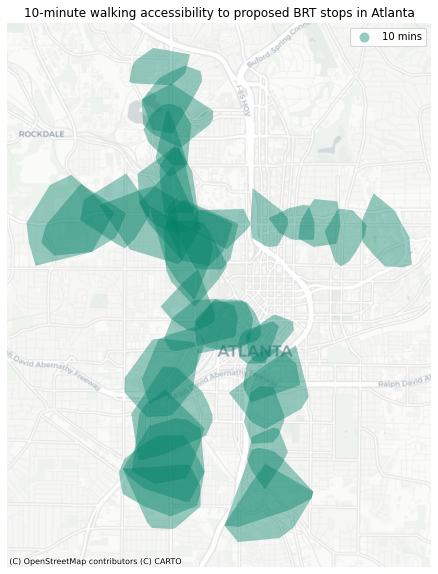

In [28]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add isochrones
output.plot(alpha=.4,
               ax=ax,
               column='time',
               cmap='summer',
               legend=True,
               zorder=20)

# no axis
ax.axis('off')

# title
ax.set_title('10-minute walking accessibility to proposed BRT stops in Atlanta')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Next steps: spatial join and demographic analysis
What we have so far:
* Census data for race, nativity, and commute mode - merged into a single gdf (ATL_census)
* Isochrones for 5, 10, and 15 minute walks from each BRT stop (output)

What comes next:
* Perform a spatial join on the 10 minute isochrone and the census data
* Produce basic stats for tracts that intersect the isochorone
* Cool maps?

In [29]:
output = output.to_crs(3857)
#ATL_census was previoulsy in EPSG:4326
ATL_census = ATL_census.to_crs(3857)

In [30]:
type(ATL_census)

geopandas.geodataframe.GeoDataFrame

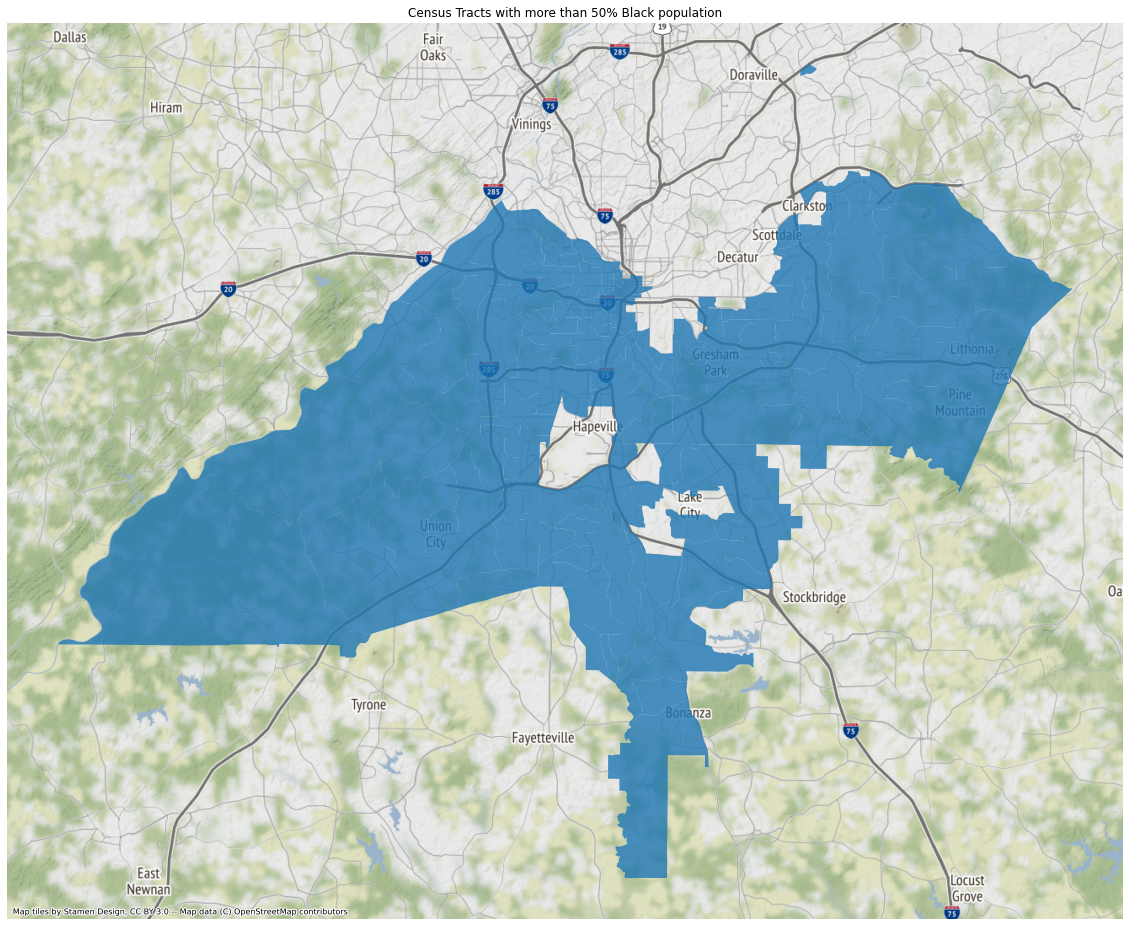

In [46]:
fig, ax = plt.subplots(figsize=(20,20))
ATL_census[ATL_census['Percent Black'] > 50].plot(ax=ax,
                                                  alpha=.8)
ax.axis('off')
ax.set_title('Census Tracts with more than 50% Black population')
ctx.add_basemap(ax)

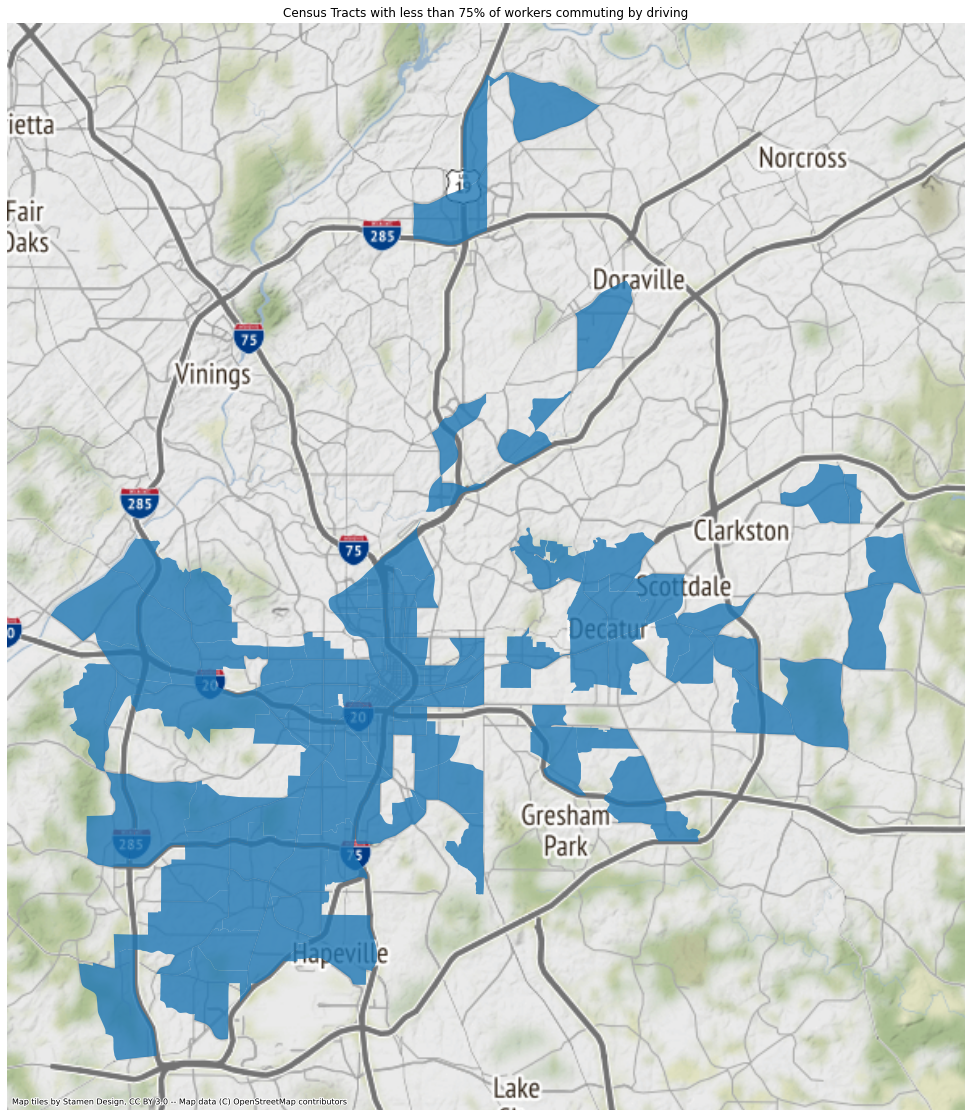

In [49]:
fig, ax = plt.subplots(figsize=(20,20))
ATL_census[ATL_census['Percent Driving'] < 75].plot(ax=ax,
                                                  alpha=.8)
ax.axis('off')
ax.set_title('Census Tracts with less than 75% of workers commuting by driving')
ctx.add_basemap(ax)

In [31]:
output.shape

(41, 2)

In [32]:
ATL_census.shape

(399, 55)

In [33]:
tracts_served = gpd.sjoin(ATL_census, output, op='intersects')

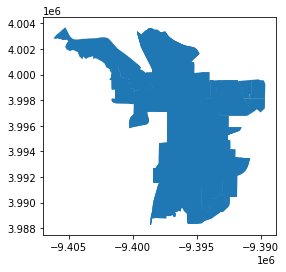

In [34]:
tracts_served.plot()

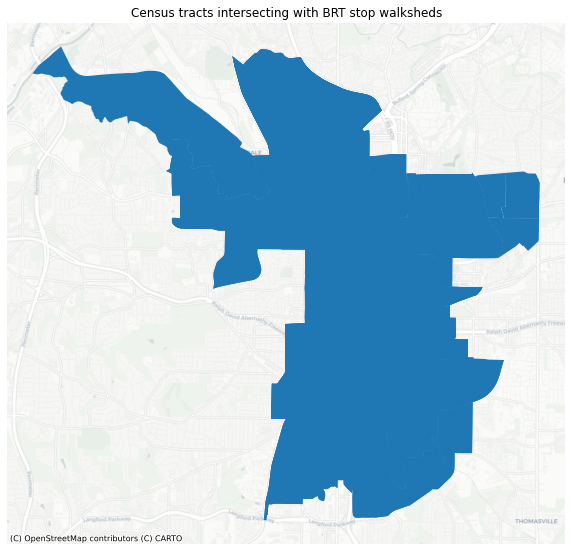

In [35]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))



# add isochrones
tracts_served.plot(ax=ax,
               legend=True,
               zorder=20)

# no axis
ax.axis('off')

# title
ax.set_title('Census tracts intersecting with BRT stop walksheds')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## First impressions
I think it worked! The tracts_served gdf maps out roughly to the BRT route map. Using op='intersects' in the spatial join argument returns a very big batch of tracts that encompasses the entire Downtown and Midtown areas, plus some definite outliers like that arm extending far northwest, all the way to I-285 (our main loop highway). However, when I tested sjoin with op='within' or 'contains' I got very few tracts. So the concept works, but I would need to come up with a better method to more accurately represent the areas served. The most obvious solutions in my mind are zooming the analysis in to the census block level, which should reduce some of these more outlying results, or generating smaller walksheds, say 8 minutes, that will still catch many residents in the 10-minute walkshed because of the 'intersects' method. I'll have to think about how to proceed, but for now, I know that the concept works, and some basic analysis of the captured tracts' demographics will hopefully be interesting.

I also need to figure out how to produce weighted data for the tracts_served dataset. For example, I'm not sure how to produce a (cringe) pie chart displaying commute mode for the whole set. I know it's not too complicated, but that's a matter for the coming weeks.

In [36]:
tracts_served.shape

(188, 57)

In [37]:
tracts_served['Percent Public Transit'].describe()

count    188.000000
mean      14.934654
std       10.689803
min        0.000000
25%        6.628855
50%       11.122661
75%       24.875622
max       36.820652
Name: Percent Public Transit, dtype: float64

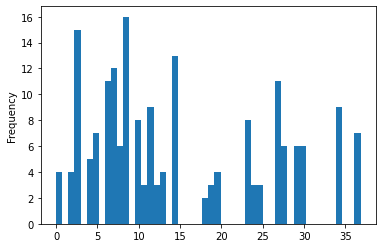

In [38]:
tracts_served['Percent Public Transit'].plot.hist(bins=50)

In [39]:
tracts_served['Percent Black'].describe()

count    188.000000
mean      64.275326
std       26.483058
min        3.539446
25%       39.012346
50%       72.289576
75%       87.953092
max      100.000000
Name: Percent Black, dtype: float64

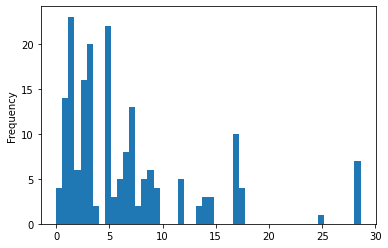

In [40]:
tracts_served['Percent Foreign-Born'].plot.hist(bins=50)

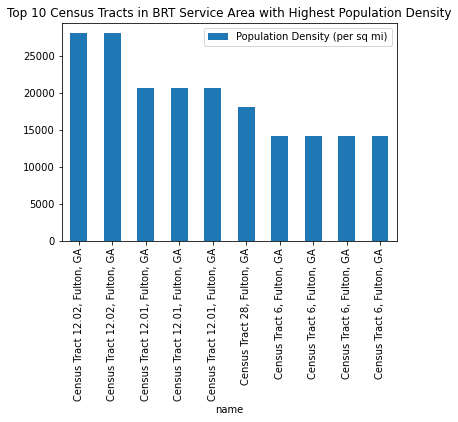

In [41]:
#to get this to work, I had to made the gdf into a pandas dataframe - there is probably a simpler way using matplotlib rather than pandas plot
tracts_served_bydensity = pd.DataFrame(tracts_served)
tracts_served_bydensity = tracts_served_bydensity.sort_values(by='Population Density (per sq mi)',ascending=False)
tracts_served_bydensity[['name','Population Density (per sq mi)']].head(10)
tracts_served_bydensity.head(10).plot.bar(x='name',
                                          y='Population Density (per sq mi)', 
                                          title='Top 10 Census Tracts in BRT Service Area with Highest Population Density')

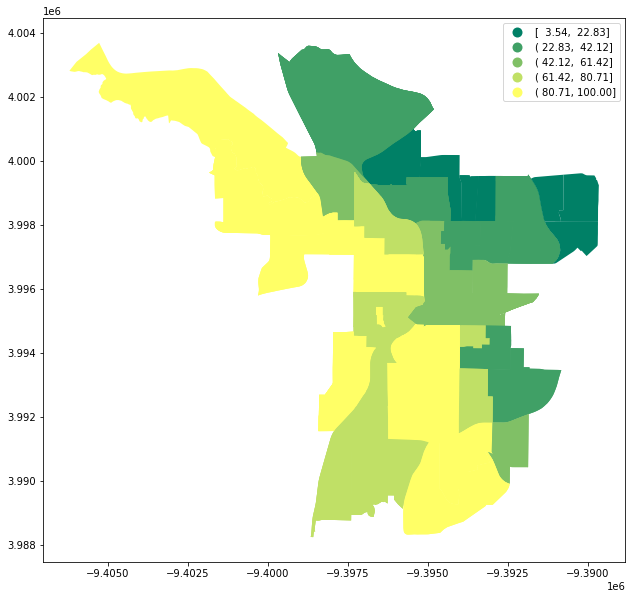

In [42]:
tracts_served.plot(figsize=(12,10),
                 column='Percent Black',
                 legend=True,
                 cmap='summer',
                 scheme='equal_interval')

# Visualization
The MARTA rail data is from the MARTA Routes shapefile hosted by the Atlanta Regional Commission's Open Data portal (https://opendata.atlantaregional.com/datasets/COSS::marta-routes), sorted for only rail as 'route_type' = '1'.


In [43]:
MARTA = gpd.read_file('data/5ca617a1-f700-4a63-b048-f2b854f625b72020330-1-rxyg14.qu0n9.shp')
MARTA_rail = MARTA.loc[MARTA['route_type'] == '1']
MARTA_rail['color'] = ''
MARTA_rail.loc[MARTA_rail['route_shor'] == 'GOLD', 'color'] = 'yellow'
MARTA_rail.loc[MARTA_rail['route_shor'] == 'RED', 'color'] = 'red'
MARTA_rail.loc[MARTA_rail['route_shor'] == 'GREEN', 'color'] = 'green'
MARTA_rail.loc[MARTA_rail['route_shor'] == 'BLUE', 'color'] = 'blue'
MARTA_rail = MARTA_rail.to_crs(epsg=3857)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


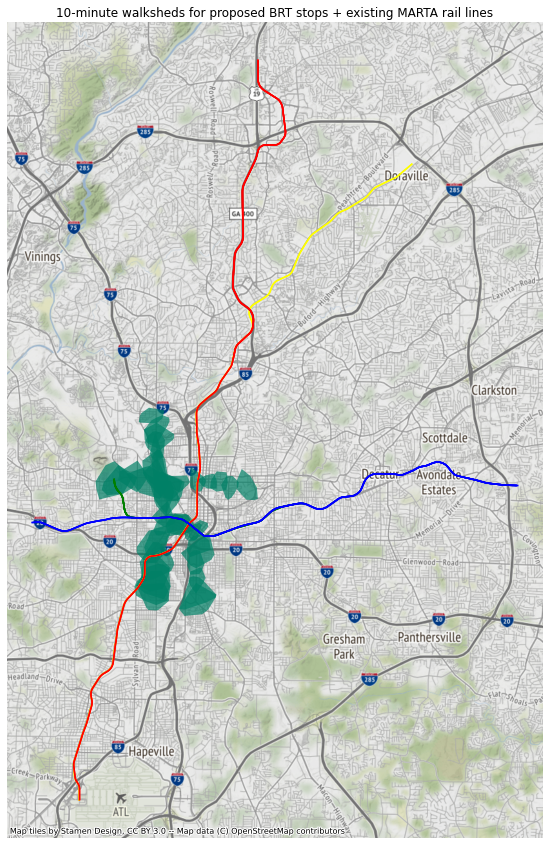

In [44]:
#MARTA base
base = MARTA_rail.plot(figsize=(15,15),color=MARTA_rail['color'])
base.axis('off')
# add isochrones
output.plot(alpha=.7,
         ax=base,
         cmap='summer',   
         column='time')

# no axis
ax.axis('off')

# title
base.set_title('10-minute walksheds for proposed BRT stops + existing MARTA rail lines')

# add a basemap
ctx.add_basemap(base)

# Credits
Andrew wrote this notebook, and Aziz wrote the Los Angeles notebook. We collaborated on selecting which Census tables to use and troubleshooting the cleaning process. We each found, modified, or created the necessary data for BRT lines/stops for our respective locations. We discussed how to best make useful graphs and visualizations, but did our own work to produce them. Andrew wrote the function for generating isochrones from lat/lon data located in any given geodataframe.